In [1]:
!pip install rasterio xarray dask matplotlib netCDF4 requests


In [2]:
import rasterio
import xarray as xr
import numpy as np
import dask.array as da

# Load TIFF from Google Cloud Storage
#tiff_filename = 'https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2020_30_sec_2020.tif'
tiff_filename = 'https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2015_30_sec_2015.tif'

with rasterio.open(tiff_filename) as src:
    data = src.read(1)  # Read the first band (population density)
    bounds = src.bounds
    crs = src.crs
    print("Coordinate reference system:", crs)

    # Convert the TIFF data into an xarray DataArray with chunking for efficient analysis
    da = xr.DataArray(
        da.from_array(data, chunks=(512, 512)),  # Convert to Dask array for efficient processing
        dims=("y", "x"),
        coords={
            "y": np.linspace(bounds.top, bounds.bottom, data.shape[0]),
            "x": np.linspace(bounds.left, bounds.right, data.shape[1]),
        },
        attrs={"transform": str(src.transform), "crs": str(src.crs)}
    )


Coordinate reference system: EPSG:4326


In [3]:
# Compute basic statistics to understand population density
mean_value = da.mean().compute()
min_value = da.min().compute()
max_value = da.max().compute()
std_value = da.std().compute()

print(f"Mean Population Density: {mean_value} persons/km²")
print(f"Min Population Density: {min_value} persons/km²")
print(f"Max Population Density: {max_value} persons/km²")
print(f"Standard Deviation: {std_value} persons/km²")


Mean Population Density: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(-7601.9565, dtype=float32) persons/km²
Min Population Density: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(-9999., dtype=float32) persons/km²
Max Population Density: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(483318.22, dtype=float32) persons/km²
Standard Deviation: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(4286.2134, dtype=float32) persons/km²


In [4]:
# Step 4: Mask No-Data Values
# No-data value is -9999; replace it with NaN for analysis
masked_da = da.where(da != -9999, np.nan)

# Step 5: Compute Basic Statistics (Ignoring NaN Values)
mean_value = masked_da.mean().compute(skipna=True)
min_value = masked_da.min().compute(skipna=True)
max_value = masked_da.max().compute(skipna=True)
std_value = masked_da.std().compute(skipna=True)

print(f"Mean Population Density: {mean_value} persons/km²")
print(f"Min Population Density: {min_value} persons/km²")
print(f"Max Population Density: {max_value} persons/km²")
print(f"Standard Deviation: {std_value} persons/km²")

Mean Population Density: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(46.038937, dtype=float32) persons/km²
Min Population Density: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(0., dtype=float32) persons/km²
Max Population Density: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(483318.22, dtype=float32) persons/km²
Standard Deviation: <xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' ()> Size: 4B
array(404.5045, dtype=float32) persons/km²


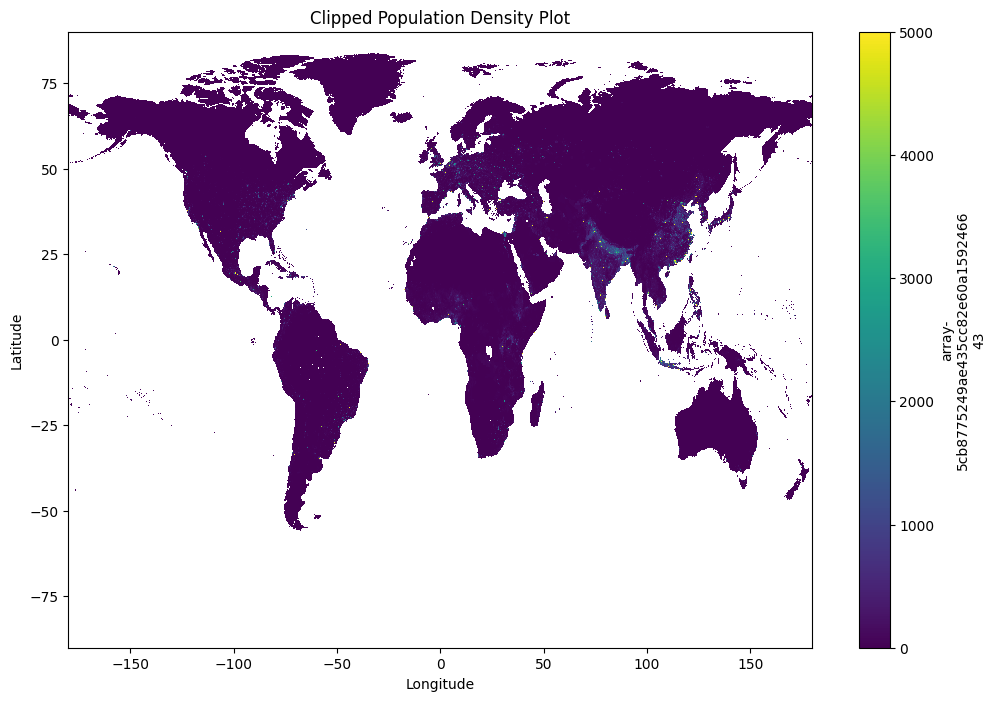

In [5]:
# Step 6: Optimize Visualization - Downsampling and Clipping
import matplotlib.pyplot as plt
# Downsample the dataset to reduce memory load for visualization
downsampled_da = masked_da.coarsen(x=10, y=10, boundary='trim').mean()

# Clip data to a meaningful range for visualization
clipped = downsampled_da.clip(min=0, max=5000).compute()


# Plot the clipped and downsampled population density data
clipped.plot(figsize=(12, 8), cmap='viridis')
plt.title("Clipped Population Density Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

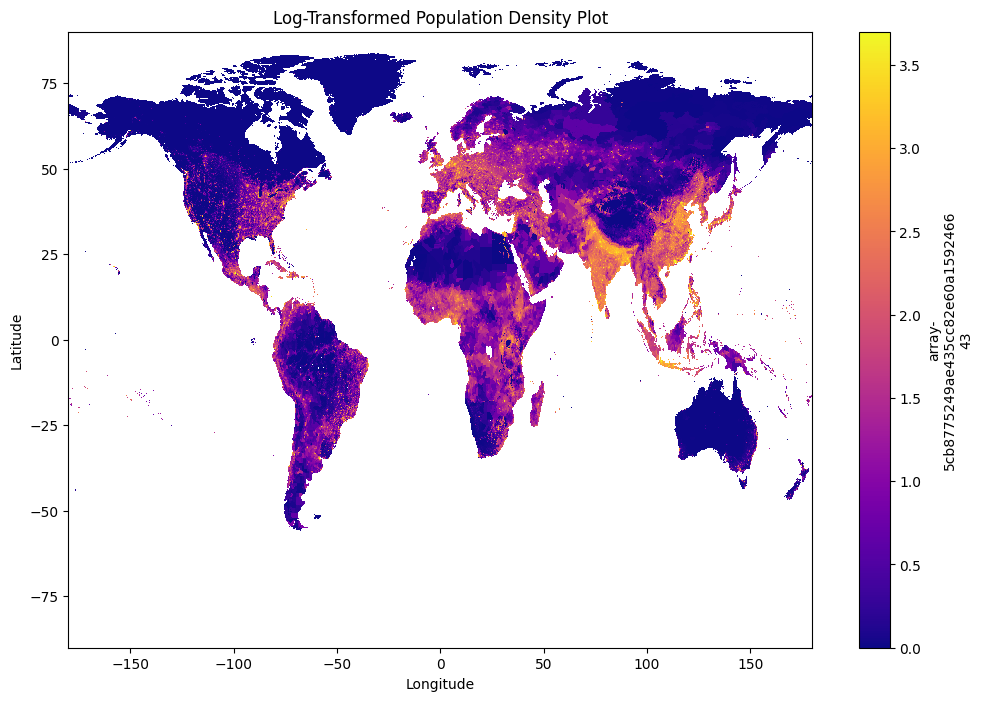

In [6]:
# Apply a logarithmic transformation to improve contrast
log_clipped = np.log10(clipped + 1)  # Adding 1 to avoid log(0)

# Convert back to xarray DataArray to leverage its plotting method
log_clipped_da = xr.DataArray(log_clipped, 
                              dims=clipped.dims, 
                              coords=clipped.coords, 
                              attrs=clipped.attrs)

# Plot the log-transformed data using xarray's built-in plot method
log_clipped_da.plot(figsize=(12, 8), cmap='plasma')
plt.title("Log-Transformed Population Density Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


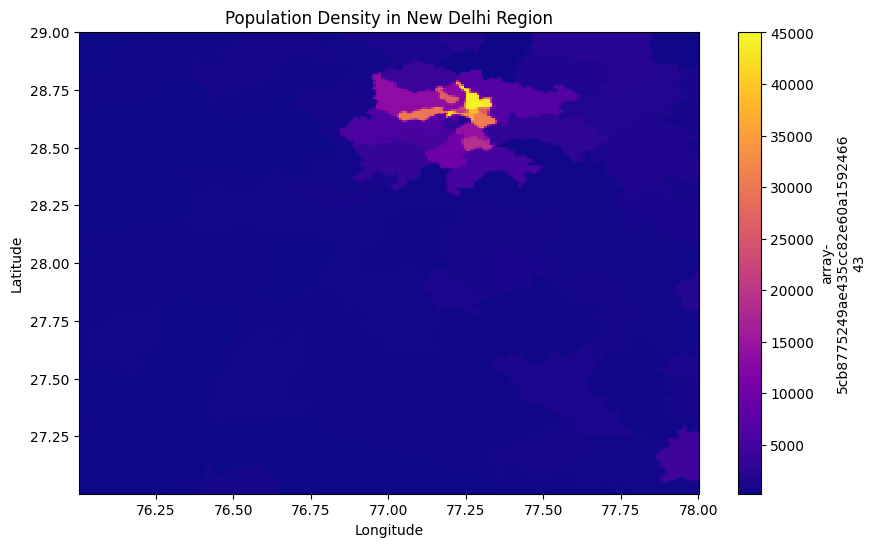

In [7]:
# Plot the Region of Interest (e.g., around New Delhi, India)
delhi_roi = masked_da.sel(x=slice(76, 78), y=slice(29, 27)).compute()
delhi_roi.plot(figsize=(10, 6), cmap='plasma')
plt.title("Population Density in New Delhi Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

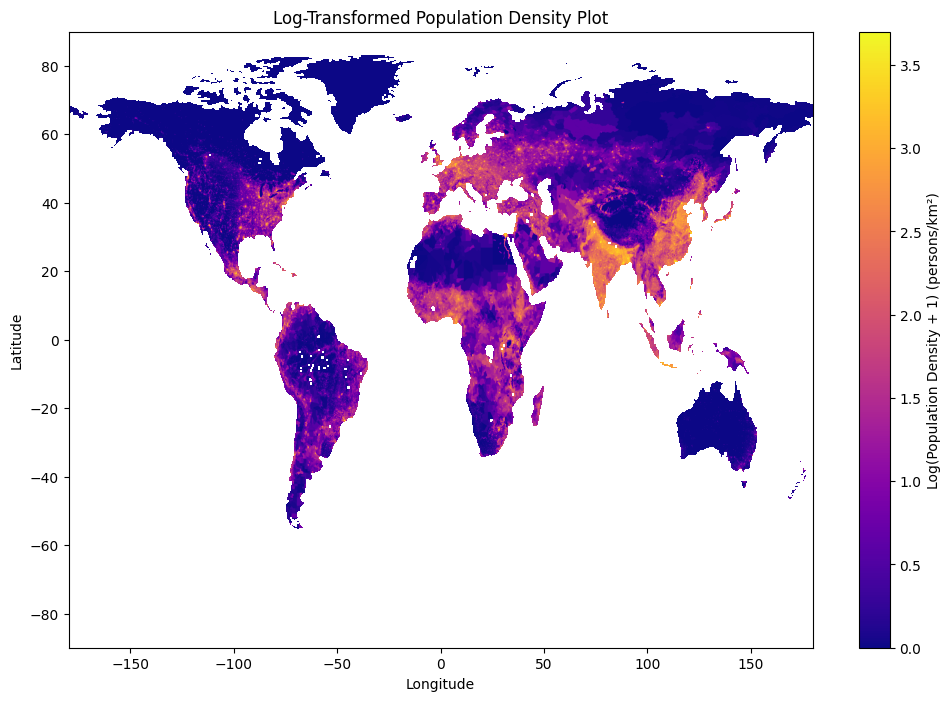

In [8]:
# Import matplotlib to plot with imshow and add a colorbar manually
fig, ax = plt.subplots(figsize=(12, 8))
# Use imshow to plot the log-transformed data
im = ax.imshow(log_clipped, cmap='plasma', origin='upper', aspect='auto', extent=[clipped.x.min(), clipped.x.max(), clipped.y.min(), clipped.y.max()])
plt.title("Log-Transformed Population Density Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Add colorbar with correct mappable (im)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Log(Population Density + 1) (persons/km²)")
plt.show()


In [9]:
# Select a more populated region around Los Angeles, California
la_roi = masked_da.sel(x=slice(-119, -117), y=slice(33, 35)).compute()

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(la_roi))
print("Number of valid data points in Los Angeles region:", valid_data_points)

# If valid data points exist, proceed with visualization
if valid_data_points > 0:
    # Fill NaN values with 0 for visualization purposes
    la_roi_filled = la_roi.fillna(0)

    # Apply a logarithmic transformation to improve contrast
    log_la_roi = np.log10(la_roi_filled + 1)  # Adding 1 to avoid log(0)

    # Convert back to xarray DataArray to leverage its plotting method
    log_la_roi_da = xr.DataArray(log_la_roi, 
                                 dims=la_roi.dims, 
                                 coords=la_roi.coords, 
                                 attrs=la_roi.attrs)

    # Plot the log-transformed data
    log_la_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in Los Angeles Region")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


Number of valid data points in Los Angeles region: 0
No valid data points found in the selected region.


In [10]:
# Step 1: Select the Region of Interest - Los Angeles Area (Approximate Coordinates)
la_roi = masked_da.sel(x=slice(-119, -117), y=slice(33, 35)).compute()

# Step 2: Check if There Are Any Valid Data Points
valid_data_points = np.count_nonzero(~np.isnan(la_roi))
print("Number of valid data points in Los Angeles region:", valid_data_points)

if valid_data_points > 0:
    # Step 3: Fill NaN Values for Visualization Purposes
    la_roi_filled = la_roi.fillna(0)

    # Step 4: Apply Logarithmic Transformation
    log_la_roi = np.log10(la_roi_filled + 1)  # Adding 1 to avoid log(0)

    # Step 5: Convert to xarray DataArray and Plot
    log_la_roi_da = xr.DataArray(log_la_roi, 
                                 dims=la_roi.dims, 
                                 coords=la_roi.coords, 
                                 attrs=la_roi.attrs)

    # Plot the Log-Transformed Data
    log_la_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in Los Angeles Region")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


Number of valid data points in Los Angeles region: 0
No valid data points found in the selected region.


In [11]:
# Select a broader region (e.g., Western United States)
us_west_roi = masked_da.sel(x=slice(-125, -114), y=slice(32, 42)).compute()

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(us_west_roi))
print("Number of valid data points in the Western United States region:", valid_data_points)

if valid_data_points > 0:
    # Fill NaN values with 0 for visualization purposes
    us_west_roi_filled = us_west_roi.fillna(0)

    # Apply a logarithmic transformation to improve contrast
    log_us_west_roi = np.log10(us_west_roi_filled + 1)  # Adding 1 to avoid log(0)

    # Convert back to xarray DataArray to leverage its plotting method
    log_us_west_roi_da = xr.DataArray(log_us_west_roi, 
                                      dims=us_west_roi.dims, 
                                      coords=us_west_roi.coords, 
                                      attrs=us_west_roi.attrs)

    # Plot the log-transformed data
    log_us_west_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in the Western United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


Number of valid data points in the Western United States region: 0
No valid data points found in the selected region.


In [12]:
us_west_roi = masked_da.sel(x=slice(-125, -114), y=slice(32, 42)).compute()
us_west_roi

<xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' (y: 0, x: 1320)> Size: 0B
array([], shape=(0, 1320), dtype=float32)
Coordinates:
  * y        (y) float64 0B 
  * x        (x) float64 11kB -125.0 -125.0 -125.0 ... -114.0 -114.0 -114.0
Attributes:
    transform:  | 0.01, 0.00,-180.00|\n| 0.00,-0.01, 90.00|\n| 0.00, 0.00, 1.00|
    crs:        EPSG:4326

In [13]:
# Inspect the available latitude and longitude ranges in the dataset
print("Latitude (y) range:", masked_da.y.min().item(), "to", masked_da.y.max().item())
print("Longitude (x) range:", masked_da.x.min().item(), "to", masked_da.x.max().item())


Latitude (y) range: -90.0 to 89.99999999999991
Longitude (x) range: -180.0 to 179.99999999999983


In [14]:
masked_da

<xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' (y: 21600, x: 43200)> Size: 4GB
dask.array<where, shape=(21600, 43200), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 173kB 90.0 89.99 89.98 89.97 ... -89.98 -89.99 -90.0
  * x        (x) float64 346kB -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    transform:  | 0.01, 0.00,-180.00|\n| 0.00,-0.01, 90.00|\n| 0.00, 0.00, 1.00|
    crs:        EPSG:4326

In [15]:
# Select a broader region including California and neighboring areas
california_broad_roi = masked_da.sel(x=slice(-170, 110), y=slice(25, 45)).compute()

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(california_broad_roi))
print("Number of valid data points in the broader California region:", valid_data_points)

if valid_data_points > 0:
    # Fill NaN values with 0 for visualization purposes
    california_broad_roi_filled = california_broad_roi.fillna(0)

    # Apply a logarithmic transformation to improve contrast
    log_california_broad_roi = np.log10(california_broad_roi_filled + 1)  # Adding 1 to avoid log(0)

    # Convert back to xarray DataArray to leverage its plotting method
    log_california_broad_roi_da = xr.DataArray(log_california_broad_roi, 
                                               dims=california_broad_roi.dims, 
                                               coords=california_broad_roi.coords, 
                                               attrs=california_broad_roi.attrs)

    # Plot the log-transformed data
    log_california_broad_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in Broader California Region")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


Number of valid data points in the broader California region: 0
No valid data points found in the selected region.


In [16]:
california_broad_roi

<xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' (y: 0, x: 33600)> Size: 0B
array([], shape=(0, 33600), dtype=float32)
Coordinates:
  * y        (y) float64 0B 
  * x        (x) float64 269kB -170.0 -170.0 -170.0 -170.0 ... 110.0 110.0 110.0
Attributes:
    transform:  | 0.01, 0.00,-180.00|\n| 0.00,-0.01, 90.00|\n| 0.00, 0.00, 1.00|
    crs:        EPSG:4326

In [17]:
delhi_roi = masked_da.sel(x=slice(76, 78), y=slice(29, 27)).compute()

delhi_roi

<xarray.DataArray 'array-5cb8775249ae435cc82e60a159246643' (y: 240, x: 240)> Size: 230kB
array([[366.59772, 366.59775, 366.59775, ..., 565.1775 , 565.1775 ,
        565.1775 ],
       [366.59772, 366.59775, 366.59775, ..., 565.1775 , 565.1775 ,
        565.17755],
       [366.59772, 366.59775, 366.59775, ..., 565.1775 , 565.17755,
        565.1775 ],
       ...,
       [285.54816, 285.54816, 285.54816, ..., 665.1234 , 759.2143 ,
        785.3635 ],
       [285.54816, 285.5482 , 285.5482 , ..., 635.0316 , 637.98596,
        734.9049 ],
       [285.54816, 285.54816, 285.54813, ..., 635.0317 , 635.0317 ,
        674.9118 ]], dtype=float32)
Coordinates:
  * y        (y) float64 2kB 29.0 28.99 28.98 28.97 ... 27.03 27.02 27.01 27.01
  * x        (x) float64 2kB 76.01 76.01 76.02 76.03 ... 77.97 77.98 77.99 78.0
Attributes:
    transform:  | 0.01, 0.00,-180.00|\n| 0.00,-0.01, 90.00|\n| 0.00, 0.00, 1.00|
    crs:        EPSG:4326

In [18]:
print("Available longitude values (x):", masked_da.x.values)
print("Available latitude values (y):", masked_da.y.values)


Available longitude values (x): [-180.         -179.99166647 -179.98333295 ...  179.98333295  179.99166647
  180.        ]
Available latitude values (y): [ 90.          89.99166628  89.98333256 ... -89.98333256 -89.99166628
 -90.        ]


In [19]:
# Print available x and y values to understand their range
print("Longitude range:", masked_da.x.values)
print("Latitude range:", masked_da.y.values)

# Adjust the region of interest selection based on the available x and y values
# Make sure the range covers areas with actual data
california_broad_roi = masked_da.sel(x=slice(-130, -110), y=slice(25, 45)).compute()

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(california_broad_roi))
print("Number of valid data points in the broader California region:", valid_data_points)

if valid_data_points > 0:
    # Proceed with further analysis and visualization
    california_broad_roi_filled = california_broad_roi.fillna(0)
    log_california_broad_roi = np.log10(california_broad_roi_filled + 1)

    log_california_broad_roi_da = xr.DataArray(log_california_broad_roi, 
                                               dims=california_broad_roi.dims, 
                                               coords=california_broad_roi.coords, 
                                               attrs=california_broad_roi.attrs)

    log_california_broad_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in Broader California Region")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


Longitude range: [-180.         -179.99166647 -179.98333295 ...  179.98333295  179.99166647
  180.        ]
Latitude range: [ 90.          89.99166628  89.98333256 ... -89.98333256 -89.99166628
 -90.        ]
Number of valid data points in the broader California region: 0
No valid data points found in the selected region.


In [20]:
# # Plot the masked global dataset to see if there are populated regions
# masked_da.plot(figsize=(12, 8), cmap='viridis')
# plt.title("Global Population Density Plot (Masked, No Downsampling)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()


In [21]:
# # Plot histogram to see the distribution of population density values globally
# masked_da.plot.hist(bins=100, alpha=0.7)
# plt.title("Histogram of Population Density Values (Global)")
# plt.xlabel("Population Density (persons/km²)")
# plt.ylabel("Frequency")
# plt.show()


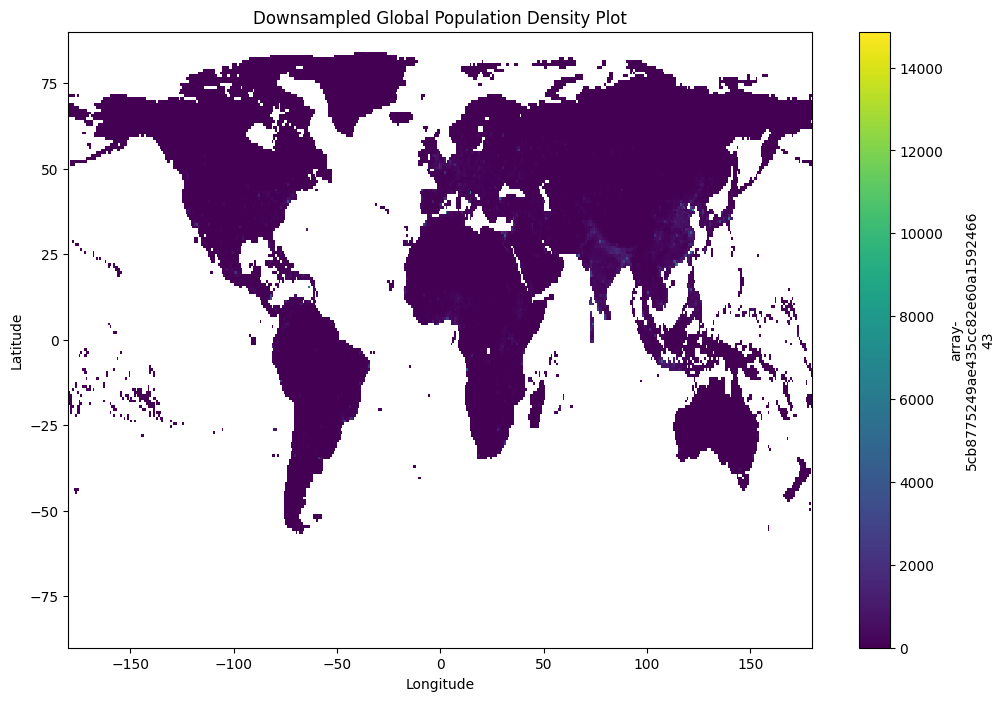

In [22]:
# Downsample the dataset to make it smaller for visualization purposes
import matplotlib.pyplot as plt
downsampled_da = masked_da.coarsen(x=100, y=100, boundary='trim').mean().compute()

# Plot the downsampled global dataset to get an overview
downsampled_da.plot(figsize=(12, 8), cmap='viridis')
plt.title("Downsampled Global Population Density Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [23]:
# Define ranges for smaller tiles (e.g., 6 tiles)
x_ranges = [slice(-180, -120), slice(-120, -60), slice(-60, 0), slice(0, 60), slice(60, 120), slice(120, 180)]
y_ranges = [slice(-90, -30), slice(-30, 30), slice(30, 90)]

# Loop through each tile and visualize to check for data presence
for x_range in x_ranges:
    for y_range in y_ranges:
        try:
            # Select the specific tile
            tile = masked_da.sel(x=x_range, y=y_range).compute()
            
            # Check if there are valid data points in this tile
            valid_points = np.count_nonzero(~np.isnan(tile))
            if valid_points > 0:
                print(f"Valid data points found in tile with x range {x_range} and y range {y_range}: {valid_points}")
                
                # Plot the tile to inspect data
                tile.plot(figsize=(10, 6), cmap='viridis')
                plt.title(f"Population Density in Tile (x: {x_range}, y: {y_range})")
                plt.xlabel("Longitude")
                plt.ylabel("Latitude")
                plt.show()
            else:
                print(f"No valid data points in tile with x range {x_range} and y range {y_range}")
        except Exception as e:
            print(f"Error visualizing tile with x range {x_range} and y range {y_range}: {e}")


No valid data points in tile with x range slice(-180, -120, None) and y range slice(-90, -30, None)
No valid data points in tile with x range slice(-180, -120, None) and y range slice(-30, 30, None)
No valid data points in tile with x range slice(-180, -120, None) and y range slice(30, 90, None)
No valid data points in tile with x range slice(-120, -60, None) and y range slice(-90, -30, None)
No valid data points in tile with x range slice(-120, -60, None) and y range slice(-30, 30, None)
No valid data points in tile with x range slice(-120, -60, None) and y range slice(30, 90, None)
No valid data points in tile with x range slice(-60, 0, None) and y range slice(-90, -30, None)
No valid data points in tile with x range slice(-60, 0, None) and y range slice(-30, 30, None)
No valid data points in tile with x range slice(-60, 0, None) and y range slice(30, 90, None)
No valid data points in tile with x range slice(0, 60, None) and y range slice(-90, -30, None)
No valid data points in tile 

In [24]:
# Check the metadata of the TIFF file to verify information
import rasterio

with rasterio.open(tiff_filename) as src:
    print("Dataset Metadata:", src.meta)
    print("Description:", src.descriptions)
    print("Number of Bands:", src.count)
    print("No Data Value:", src.nodata)


Dataset Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333333333333, 0.0, -180.0,
       0.0, -0.00833333333333333, 89.99999999999991)}
Description: ('band_data',)
Number of Bands: 1
No Data Value: -9999.0


In [25]:
# Open the TIFF file and read a sample of the data to check if any values are not equal to -9999
import rasterio

with rasterio.open(tiff_filename) as src:
    # Read a portion of the data to inspect sample values
    data = src.read(1)  # Read the first (and only) band

    # Check if there are any values different from the no-data value (-9999)
    unique_values = np.unique(data)
    print("Unique values in the dataset:", unique_values)

    # Count number of valid (non -9999) values
    valid_values_count = np.count_nonzero(data != -9999)
    print("Number of valid data points:", valid_values_count)


Unique values in the dataset: [-9.9990000e+03  0.0000000e+00  1.0000458e-06 ...  2.3589478e+05
  3.5599925e+05  4.8331822e+05]
Number of valid data points: 222670056


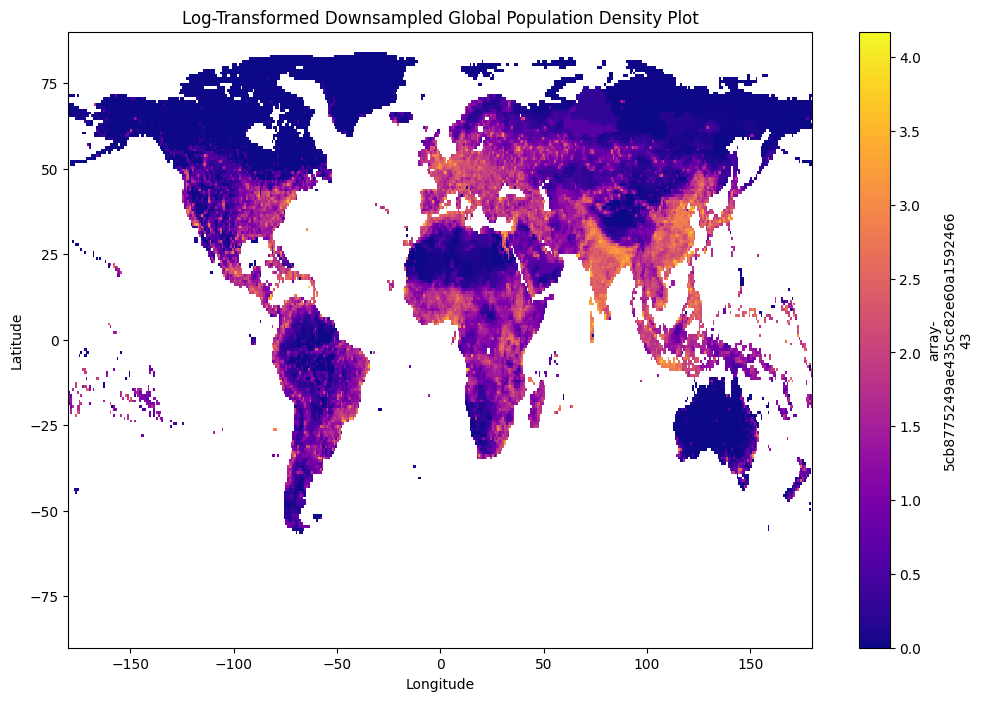

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Downsample the dataset to make it easier to visualize without overloading memory
downsample_factor = 100  # Reduce by factor of 100 for visualization purposes
downsampled_da = masked_da.coarsen(x=downsample_factor, y=downsample_factor, boundary='trim').mean().compute()

# Apply a logarithmic transformation to the downsampled data
# Adding 1 to avoid issues with log(0) for zero values
log_downsampled_da = np.log10(downsampled_da + 1)

# Convert back to an xarray DataArray to leverage the plotting functionality
log_downsampled_da_xr = xr.DataArray(
    log_downsampled_da, 
    dims=downsampled_da.dims, 
    coords=downsampled_da.coords, 
    attrs=downsampled_da.attrs
)

# Plot the log-transformed data
log_downsampled_da_xr.plot(figsize=(12, 8), cmap='plasma')
plt.title("Log-Transformed Downsampled Global Population Density Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Number of valid data points in the India region: 5381175


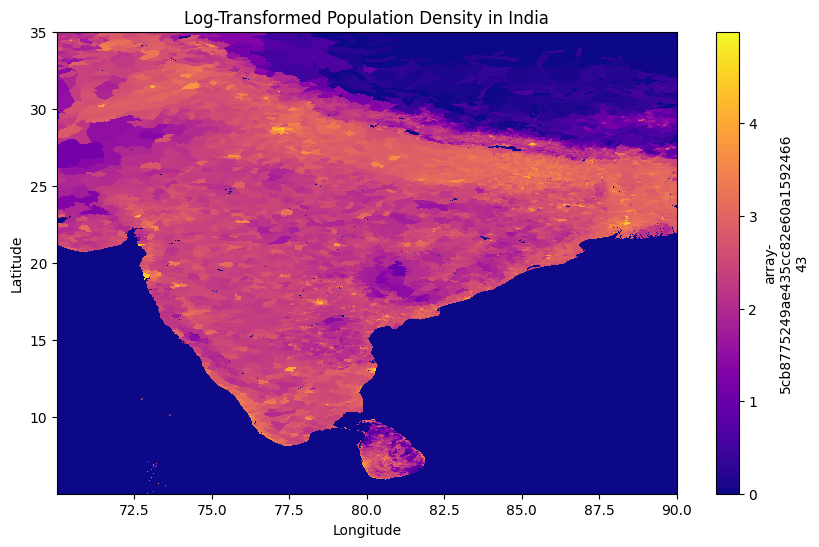

In [27]:
# Adjust the latitude and longitude selection to match the dataset's coordinate system
india_roi = masked_da.sel(x=slice(70, 90), y=slice(35, 5)).compute()  # Ensure latitude is in descending order

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(india_roi))
print("Number of valid data points in the India region:", valid_data_points)

if valid_data_points > 0:
    # Fill NaN values for visualization purposes
    india_roi_filled = india_roi.fillna(0)

    # Apply a logarithmic transformation
    log_india_roi = np.log10(india_roi_filled + 1)

    # Convert to xarray DataArray to plot
    log_india_roi_da = xr.DataArray(
        log_india_roi,
        dims=india_roi.dims,
        coords=india_roi.coords,
        attrs=india_roi.attrs
    )

    # Plot the log-transformed data
    log_india_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in India")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


In [28]:
# Print available x and y values to understand their range
print("Longitude range:", masked_da.x.values[:10], "...", masked_da.x.values[-10:])  # Print first and last 10 values of longitude
print("Latitude range:", masked_da.y.values[:10], "...", masked_da.y.values[-10:])    # Print first and last 10 values of latitude


Longitude range: [-180.         -179.99166647 -179.98333295 -179.97499942 -179.9666659
 -179.95833237 -179.94999884 -179.94166532 -179.93333179 -179.92499826] ... [179.92499826 179.93333179 179.94166532 179.94999884 179.95833237
 179.9666659  179.97499942 179.98333295 179.99166647 180.        ]
Latitude range: [90.         89.99166628 89.98333256 89.97499884 89.96666512 89.9583314
 89.94999769 89.94166397 89.93333025 89.92499653] ... [-89.92499653 -89.93333025 -89.94166397 -89.94999769 -89.9583314
 -89.96666512 -89.97499884 -89.98333256 -89.99166628 -90.        ]


Number of valid data points in the California region: 2601750


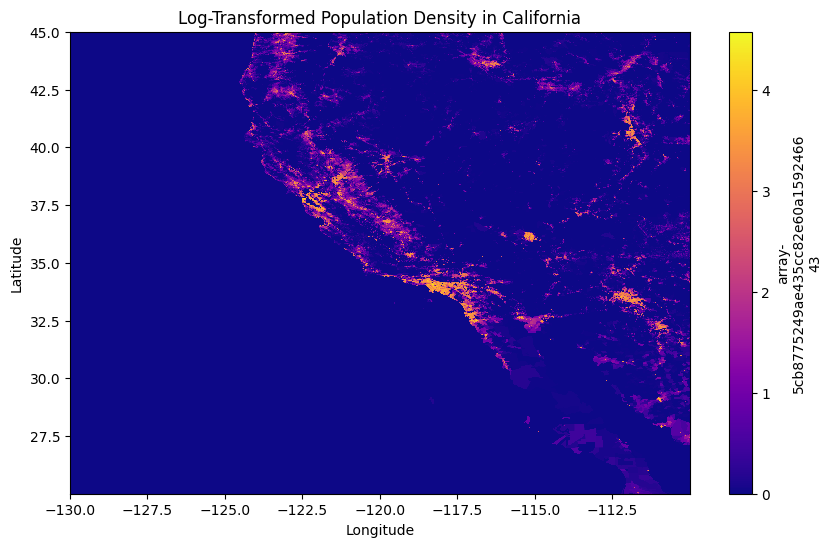

In [29]:
# Adjust the latitude and longitude selection to match the dataset's coordinate system
california_broad_roi = masked_da.sel(x=slice(-130, -110), y=slice(45, 25)).compute()

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(california_broad_roi))
print("Number of valid data points in the California region:", valid_data_points)

if valid_data_points > 0:
    # Fill NaN values for visualization purposes
    california_broad_roi_filled = california_broad_roi.fillna(0)

    # Apply a logarithmic transformation
    log_california_broad_roi = np.log10(california_broad_roi_filled + 1)
    #log_california_broad_roi = california_broad_roi

    # Convert to xarray DataArray to plot
    log_california_broad_roi_da = xr.DataArray(
        log_california_broad_roi,
        dims=california_broad_roi.dims,
        coords=california_broad_roi.coords,
        attrs=california_broad_roi.attrs
    )

    # Plot the log-transformed data
    log_california_broad_roi_da.plot(figsize=(10, 6), cmap='plasma')
    plt.title("Log-Transformed Population Density in California")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
else:
    print("No valid data points found in the selected region.")


In [30]:
# Adjust the latitude and longitude selection to match the dataset's coordinate system
california_broad_roi = masked_da.sel(x=slice(-130, -110), y=slice(45, 25)).compute()

# Check if there are any valid (non-NaN) values in the selected ROI
valid_data_points = np.count_nonzero(~np.isnan(california_broad_roi))
print("Number of valid data points in the California region:", valid_data_points)

Number of valid data points in the California region: 2601750


## Combining the datasets we have for population density: 

In [31]:
# import rasterio
# import xarray as xr
# import numpy as np



# # List of file paths for each year's dataset
# years = [2000, 2005, 2010, 2015, 2020]
# file_paths = [
#     "https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2000_30_sec_2000.tif",
# "https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2005_30_sec_2005.tif",
# "https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2010_30_sec_2010.tif",
# "https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2015_30_sec_2015.tif",
# "https://dljsq618eotzp.cloudfront.net/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2020_30_sec_2020.tif"
# ]

# # Load each year's data, apply downsampling and clipping
# data_arrays = []

# downsample_factor = 10  # Reduce resolution by factor of 10
# clip_min, clip_max = 0, 5000  # Clip population density values

# for year, path in zip(years, file_paths):
#     with rasterio.open(path) as src:
#         # Downsample the dataset
#         data = src.read(
#             1,
#             out_shape=(
#                 src.height // downsample_factor,
#                 src.width // downsample_factor
#             ),
#             resampling=rasterio.enums.Resampling.average
#         )

#         # Clip values to the specified range
#         data = np.clip(data, clip_min, clip_max)

#         # Define new coordinates for the downsampled data
#         coords = {
#             "y": np.linspace(src.bounds.top, src.bounds.bottom, data.shape[0]),
#             "x": np.linspace(src.bounds.left, src.bounds.right, data.shape[1])
#         }

#         # Create an xarray DataArray
#         da = xr.DataArray(data, dims=("y", "x"), coords=coords, name=f"population_{year}")
#         da = da.assign_coords(time=year)
#         data_arrays.append(da)

# # Combine into a single DataArray along the 'time' dimension
# population_ds = xr.concat(data_arrays, dim="time")

# # Inspect combined dataset
# print(population_ds)


## This session is for ODIAC Dataset

In [32]:
import rasterio
import numpy as np
import xarray as xr
import requests
import os

# Base URL to generate URLs for the specific files
base_url = "https://dljsq618eotzp.cloudfront.net/odiac-ffco2-monthgrid-v2023/odiac2023_1km_excl_intl_"

# Specific years to focus on
target_years = [2000, 2005, 2010, 2015, 2020]

# Directory where the downloaded files will be saved temporarily
temp_directory = "path/to/temp/odiac_tiff_files"

# Create the directory if it doesn't exist
if not os.path.exists(temp_directory):
    os.makedirs(temp_directory)

# Dictionary to store yearly averages
yearly_data = {}

# Loop through each target year to process the monthly files
for year in target_years:
    year_sum = None
    valid_months = 0

    for month in range(1, 13):
        # Generate the URL for each month
        month_str = f"{month:02}"
        file_name = f"{year}{month_str}.tif"
        file_url = f"{base_url}{file_name}"

        # Download the file temporarily
        response = requests.get(file_url, stream=True)
        if response.status_code == 200:
            temp_file_path = os.path.join(temp_directory, file_name)
            with open(temp_file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)

            # Read the file using rasterio
            with rasterio.open(temp_file_path) as src:
                # Optionally downsample to reduce data size (e.g., by a factor of 10)
                downsample_factor = 10
                data = src.read(
                    1,
                    out_shape=(
                        src.height // downsample_factor,
                        src.width // downsample_factor
                    ),
                    resampling=rasterio.enums.Resampling.average
                )

                # Add the data to the running sum for the year
                if year_sum is None:
                    year_sum = np.array(data, dtype=np.float64)
                else:
                    year_sum += data
                valid_months += 1

            # Remove the temporary file to save space
            os.remove(temp_file_path)
        else:
            print(f"Failed to download {file_url}, Status code: {response.status_code}")

    # Calculate the yearly average if all months were successfully processed
    if valid_months == 12:
        yearly_average = year_sum / valid_months
        coords = {
            "y": np.linspace(src.bounds.top, src.bounds.bottom, yearly_average.shape[0]),
            "x": np.linspace(src.bounds.left, src.bounds.right, yearly_average.shape[1])
        }

        # Store as xarray DataArray
        yearly_data[year] = xr.DataArray(yearly_average, dims=("y", "x"), coords=coords, name=f"odiac_{year}")

# Convert to xarray Dataset
yearly_ds = xr.concat(list(yearly_data.values()), dim="time")
yearly_ds = yearly_ds.assign_coords(time=target_years)

# Inspect combined dataset
print(yearly_ds)


<xarray.DataArray 'odiac_2000' (time: 5, y: 2160, x: 4320)> Size: 373MB
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999.,

In [33]:
# Aggregate the yearly data to match the population dataset (5-year intervals)
years_to_aggregate = [2000, 2005, 2010, 2015, 2020]
aggregated_data = []

for i, year in enumerate(years_to_aggregate[:-1]):
    next_year = years_to_aggregate[i + 1]
    # Extract and average the data within the 5-year range
    time_range_data = yearly_ds.sel(time=slice(year, next_year - 1)).mean(dim="time")
    aggregated_data.append(time_range_data)

# Combine the 5-year aggregated data
odiac_5yr_ds = xr.concat(aggregated_data, dim="time")
odiac_5yr_ds = odiac_5yr_ds.assign_coords(time=years_to_aggregate[:-1])

# Inspect the final aggregated dataset
print(odiac_5yr_ds)


<xarray.DataArray 'odiac_2000' (time: 4, y: 2160, x: 4320)> Size: 299MB
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999.,

## Working on something else entierely 

In [34]:
# Install necessary packages
# Run the following commands to install the required libraries:
!pip install geopandas shapely

In [35]:
import geopandas as gpd
import requests


In [36]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for ODIAC dataset 
collection_name = "odiac-ffco2-monthgrid-v2023"

In [37]:
# Read the state boundaries directly from the URL
url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
states_gdf = gpd.read_file(url)


In [38]:
# Transform CRS to WGS84 if not already
states_gdf = states_gdf.to_crs(epsg=4326)



In [39]:
# Initialize a dictionary to hold the AOIs
state_aois = {}

# Loop through each state
for idx, row in states_gdf.iterrows():
    state_name = row['NAME']  # Get the state name
    geometry = row.geometry

    # Get the bounding box of the state's geometry
    minx, miny, maxx, maxy = geometry.bounds

    # Create the bounding box coordinates
    bbox_coords = [
        [minx, miny],  # Lower-left corner (min longitude, min latitude)
        [minx, maxy],  # Upper-left corner (min longitude, max latitude)
        [maxx, maxy],  # Upper-right corner (max longitude, max latitude)
        [maxx, miny],  # Lower-right corner (max longitude, min latitude)
        [minx, miny],  # Closing the polygon by returning to the first point
    ]

    # Construct the AOI dictionary
    # state_aoi = {
    #     "type": "Feature",
    #     "properties": {"name": state_name},
    #     "geometry": {
    #         "type": "Polygon",
    #         "coordinates": [bbox_coords],
    #     },
    # }

    state_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            bbox_coords
        ],
        "type": "Polygon",
    },
}

    # Add to the dictionary
    state_aois[state_name] = state_aoi


In [40]:
for state_name, aoi in state_aois.items():
    print(f"State: {state_name}")
    coords = aoi['geometry']['coordinates'][0]
    print("Bounding Coordinates:")
    for coord in coords:
        print(f"  {coord}")
    print()


State: Mississippi
Bounding Coordinates:
  [-91.65500899999999, 30.173942999999998]
  [-91.65500899999999, 34.996052]
  [-88.097888, 34.996052]
  [-88.097888, 30.173942999999998]
  [-91.65500899999999, 30.173942999999998]

State: North Carolina
Bounding Coordinates:
  [-84.32186899999999, 33.842316]
  [-84.32186899999999, 36.588117]
  [-75.460621, 36.588117]
  [-75.460621, 33.842316]
  [-84.32186899999999, 33.842316]

State: Oklahoma
Bounding Coordinates:
  [-103.002565, 33.615832999999995]
  [-103.002565, 37.002206]
  [-94.430662, 37.002206]
  [-94.430662, 33.615832999999995]
  [-103.002565, 33.615832999999995]

State: Virginia
Bounding Coordinates:
  [-83.675395, 36.540738]
  [-83.675395, 39.466012]
  [-75.242266, 39.466012]
  [-75.242266, 36.540738]
  [-83.675395, 36.540738]

State: West Virginia
Bounding Coordinates:
  [-82.644739, 37.201482999999996]
  [-82.644739, 40.638801]
  [-77.71951899999999, 40.638801]
  [-77.71951899999999, 37.201482999999996]
  [-82.644739, 37.20148299999

In [41]:
state_aois["Texas"]

{'type': 'Feature',
 'properties': {},
 'geometry': {'coordinates': [[[-106.645646, 25.837377],
    [-106.645646, 36.500704],
    [-93.508292, 36.500704],
    [-93.508292, 25.837377],
    [-106.645646, 25.837377]]],
  'type': 'Polygon'}}

In [42]:
# Create a function that would search for a data collection in the US GHG Center STAC API

# First, we need to define the function
# The name of the function = "get_item_count"
# The argument that will be passed through the defined function = "collection_id"
def get_item_count(collection_id):

    # Set a counter for the number of items existing in the collection
    count = 0

    # Define the path to retrieve the granules (items) of the collection of interest in the STAC API
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    # Run a while loop to make HTTP requests until there are no more URLs associated with the collection in the STAC API
    while True:

        # Retrieve information about the granules by sending a "get" request to the STAC API using the defined collection path
        response = requests.get(items_url)

        # If the items do not exist, print an error message and quit the loop
        if not response.ok:
            print("error getting items")
            exit()

        # Return the results of the HTTP response as JSON
        stac = response.json()

        # Increase the "count" by the number of items (granules) returned in the response
        count += int(stac["context"].get("returned", 0))

        # Retrieve information about the next URL associated with the collection in the STAC API (if applicable)
        next = [link for link in stac["links"] if link["rel"] == "next"]

        # Exit the loop if there are no other URLs
        if not next:
            break
        
        # Ensure the information gathered by other STAC API links associated with the collection are added to the original path
        # "href" is the identifier for each of the tiles stored in the STAC API
        items_url = next[0]["href"]

    # Return the information about the total number of granules found associated with the collection
    return count

In [43]:
number_of_items = get_item_count(collection_name)

In [44]:
number_of_items

276

In [45]:
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]

In [46]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

{'id': 'odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212/map?assets=co2-emissions&rescale=-10%2C60&colormap_name=jet',
   'rel': 'previ

In [47]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items} 

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the ODIAC Fossil Fuel CO₂ Emissions collection, the parameter of interest is “co2-emissions”
asset_name = "co2-emissions"

In [48]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [49]:
items['2020-01']['collection'], items['2020-01']['id']

('odiac-ffco2-monthgrid-v2023',
 'odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202001')

In [50]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 276 items


In [51]:
# Examine the first item in the collection
items[0]

{'id': 'odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/odiac-ffco2-monthgrid-v2023/items/odiac-ffco2-monthgrid-v2023-odiac2023_1km_excl_intl_202212/map?assets=co2-emissions&rescale=-10%2C60&colormap_name=jet',
   'rel': 'previ

In [52]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"][:7],
    }

In [54]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
# This process may take a few minutes to complete 
stats = [generate_stats(item, state_aois['Texas']) for item in items]

CPU times: user 1.18 s, sys: 140 ms, total: 1.32 s
Wall time: 9min 50s


In [55]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
import pandas as pd
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["start_datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-12,0.743868,476146.87500,29.637630,539502.0625,15989563.0,1711.745381,2.614540,1.576344,0.743868,413735.0,"[[540602.0, 14.0, 3.0, 3.0, 4.0, 3.0, 3.0, 2.0...",26.75,1480782.0,540636.0,1.237146,170.576111,2022-12-01
1,2022-11,0.608937,388673.15625,24.625458,539502.0625,13285485.0,1421.688521,2.190346,1.290409,0.608937,413702.0,"[[540601.0, 15.0, 3.0, 3.0, 4.0, 2.0, 3.0, 3.0...",26.75,1480782.0,540636.0,1.015366,141.525467,2022-11-01
2,2022-10,0.617746,394160.21875,25.103348,539502.0625,13543308.0,1450.121719,2.239132,1.309075,0.617746,413665.0,"[[540601.0, 15.0, 3.0, 3.0, 4.0, 2.0, 3.0, 2.0...",26.75,1480782.0,540636.0,1.030309,144.116470,2022-10-01
3,2022-09,0.737875,472489.90625,29.611517,539502.0625,15975474.0,1711.127991,2.618091,1.563644,0.737875,413755.0,"[[540601.0, 15.0, 3.0, 3.0, 4.0, 2.0, 3.0, 3.0...",26.75,1480782.0,540636.0,1.228595,170.119186,2022-09-01
4,2022-08,0.910771,584642.43750,36.344925,539502.0625,19608162.0,2102.633230,3.200509,1.930030,0.910771,413679.0,"[[540602.0, 14.0, 3.0, 3.0, 4.0, 3.0, 3.0, 2.0...",26.75,1480782.0,540636.0,1.514735,208.829620,2022-08-01


In [ ]:
state_stats = {}

for state_name, aoi in state_aois.items():
    print(f"Generating stats for {state_name}...")
    stats_list = []
    for item in items:
        try:
            stats = generate_stats(item, aoi)
            if stats is not None:
                stats_list.append(stats)
        except Exception as e:
            print(f"Error processing item {item.get('id', 'Unknown')} for {state_name}: {e}")
    state_stats[state_name] = stats_list